In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="1" # change 0  with whatever card is available

In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import numpy as np
import random
from typing import List, Optional
import torch.optim
import copy
import matplotlib.pyplot as plt
import torchvision

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [4]:
class NAGGS(torch.optim.Optimizer):
    """Class NAGGS implements algorithm 1 from [1] which stands for the Semi
    Implicit integration of the Nesterov Accelerated Gradient (NAG) flow.

     References
    ----------
    .. [1] NAG-GS: Semi-Implicit, Accelerated and Robust Stochastic Optimizer
    """

    def __init__(self, params, lr=1e-2, mu=1.0, gamma=1.0):
        if lr < 0.0:
            raise ValueError(f"Invalid alpha: {lr}")
        if mu < 0.0:
            raise ValueError(f"Invalid mu: {mu}")

        defaults = dict(lr=lr, mu=mu, gamma=gamma)
        super().__init__(params, defaults)

    def __setstate__(self, state):
        super().__setstate__(state)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments
        ---------
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with T.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            grads = []
            v_list = []

            for p in group['params']:
                if p.grad is not None:
                    params_with_grad.append(p)
                    grads.append(p.grad)

                    state = self.state[p]
                    # Initialization
                    if len(state) == 0:
                        state['v'] = torch.clone(p).detach()

                    v_list.append(state['v'])

            naggs(params_with_grad,
                 grads,
                 v_list,
                 alpha=group['lr'],
                 mu=group['mu'],
                 gamma=group['gamma'])

        return loss


def naggs(params: List[torch.Tensor], grads: List[torch.Tensor],
         v_list: List[Optional[torch.Tensor]], alpha: float, mu: float,
         gamma: float):
    """Function naggs performs NAGGS algorithm computation.
    """

    for i, param in enumerate(params):
        grad = grads[i]
        v = v_list[i]
        # Update v
        v.add_(mu*param - grad, alpha=alpha/gamma)
        v.div_(1 + alpha*mu/gamma)

        # Update parameters
        param.add_(v, alpha=alpha)
        param.div_(1+alpha)


In [5]:
class LeNet(nn.Module):

    # network structure
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)
        self.relu = nn.ReLU()
        self.m_pool = nn.MaxPool2d((2, 2))

    def forward(self, x):
        '''
        One forward pass through the network.
        
        Args:
            x: input
        '''
        x = self.m_pool(self.relu(self.conv1(x)))
        x = self.m_pool(self.relu(self.conv2(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        '''
        Get the number of features in a batch of tensors `x`.
        '''
        size = x.size()[1:]
        return np.prod(size)


In [6]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*7 *7, out_features=600)
        self.drop = nn.Dropout(0.5)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
#         print(out.shape)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [7]:
config = {
    "batch_size": 100,
    "seed": 0,
    "weight_decay": 1e-4,
    "momentum": 0.9
}

In [8]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [9]:
set_seed(config["seed"])

In [10]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize(size=(224, 224)),
#                                 transforms.Normalize((0.5,),(0.5,),)
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                               ]
                              )
                                
# Load the data: train and test sets
# trainset = datasets.FashionMNIST("./", 
#                                  download=True, train=True,
#                                  transform=transform)
# testset = datasets.FashionMNIST("./",
#                                 download=True, train=False,
#                                 transform=transform)

trainset = datasets.CIFAR10("./", 
                                 download=True, train=True,
                                 transform=transform)
testset = datasets.CIFAR10("./",
                                download=True, train=False,
                                transform=transform)



#Data Loader
train_loader = torch.utils.data.DataLoader(trainset, 
                    batch_size=config["batch_size"], shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(testset, 
                    batch_size=config["batch_size"], shuffle=True, num_workers=4, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
# lr_range = np.logspace(-2, 0, num=10)
# lr_range = [1e-2, 1e-1, 0.15, 0.2, 0.5]
# lr_range = [1e-4, 1e-3]
lr_range = [1e-2, 1e-1, 0.15, 0.2]
print(lr_range)
config["num_epoch"] = 20
criterion = nn.CrossEntropyLoss(reduction="mean")

[0.01, 0.1, 0.15, 0.2]


In [12]:
def train_one_epoch(train_loader, model, criterion, optimizer, train_loss_batch):
    model.train()
    for batch in train_loader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        ### ===== Forward pass =====
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss_batch.append(loss.item())
#         if loss.item() >= 10: # If the loss is diverging it's better stop 
#             break

        ### ===== Backward pass =====
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [13]:
def validate_complete_data(test_loader, model):
    correct = 0.
    total = 0.
    loss = 0.
    model.eval()
    criterion = nn.CrossEntropyLoss(reduction="sum")
    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss += criterion(outputs, labels)
            predictions = torch.max(outputs, 1)[1].to(device)
            correct += (predictions == labels).sum()
            total += len(labels)
    return loss / total, correct * 100 / total 

In [14]:
conv_lr = {}
test_losses_lr = {}
test_acc_lr = {}

In [16]:
!ls /raid/

ls: cannot access '/raid/': No such file or directory


In [45]:
for lr in lr_range:
    print("lr={}".format(lr))
    conv_lr[lr] = {}
    test_losses_lr[lr] = {}
    test_acc_lr[lr] = {}
#     sgd_model = FashionCNN().to(device)
#     sgd_model = LeNet().to(device)
    sgd_model = torchvision.models.vgg11(num_classes=10, weights=None).to(device)
#     sgd_model = copy.deepcopy(alex_net).to(device)
#     adam_model = copy.deepcopy(sgd_model).to(device)
    nag_gs_model = copy.deepcopy(sgd_model).to(device)
    model_opt = [
        (nag_gs_model, NAGGS(nag_gs_model.parameters(), lr=lr, mu=config["weight_decay"]), [], "NAG-GS"),
#         (sgd_model, torch.optim.SGD(sgd_model.parameters(), lr=lr, momentum=config["momentum"], weight_decay=config["weight_decay"]), [], "SGD"),
#         (adam_model, torch.optim.Adam(adam_model.parameters(), lr=lr, weight_decay=config["weight_decay"]), [], "Adam"),
    ]
    for m, opt, train_loss_batch, name in model_opt:
        print("Optimizer = {}".format(name))
        test_loss, test_accuracy = validate_complete_data(test_loader, m)
        test_losses_lr[lr][name] = [test_loss]
        test_acc_lr[lr][name] = [test_accuracy]
        for epoch in range(config["num_epoch"]):
            train_one_epoch(train_loader, m, criterion, opt, train_loss_batch)
            test_loss, test_accuracy = validate_complete_data(test_loader, m)
            print("Epoch={}, test loss={}, test_accuracy={}".format(epoch+1, test_loss, test_accuracy))
            test_losses_lr[lr][name].append(test_loss)
            test_acc_lr[lr][name].append(test_accuracy)
        conv_lr[lr][name] = copy.deepcopy(train_loss_batch)
    torch.save({
        'model_state_dict': model_opt[0][0].state_dict(),
        'nag_gs_state_dict': model_opt[0][1].state_dict(),
    }, "./vgg11_nag-gs_lr_{}_224_epoch20".format(lr))

lr=0.01
Optimizer = NAG-GS
Epoch=1, test loss=1.3759781122207642, test_accuracy=49.37999725341797
Epoch=2, test loss=1.0412436723709106, test_accuracy=62.98999786376953
Epoch=3, test loss=0.807062029838562, test_accuracy=72.44999694824219
Epoch=4, test loss=0.7030510306358337, test_accuracy=75.47000122070312
Epoch=5, test loss=0.6750775575637817, test_accuracy=77.18999481201172
Epoch=6, test loss=0.6187040209770203, test_accuracy=79.36000061035156
Epoch=7, test loss=0.6096310615539551, test_accuracy=80.7699966430664
Epoch=8, test loss=0.6759868860244751, test_accuracy=80.58999633789062
Epoch=9, test loss=0.6613944172859192, test_accuracy=80.54999542236328
Epoch=10, test loss=0.6835634708404541, test_accuracy=81.18999481201172
Epoch=11, test loss=0.7524134516716003, test_accuracy=81.08999633789062
Epoch=12, test loss=0.7448263764381409, test_accuracy=81.25
Epoch=13, test loss=0.9078944325447083, test_accuracy=80.77999877929688
Epoch=14, test loss=0.8922863006591797, test_accuracy=81.509

RuntimeError: [enforce fail at inline_container.cc:325] . unexpected pos 637381952 vs 637381840

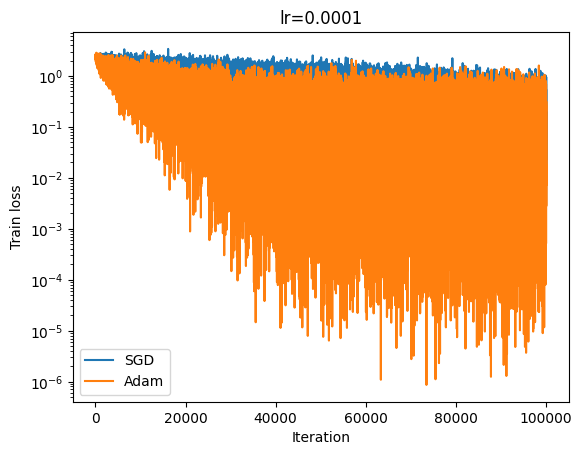

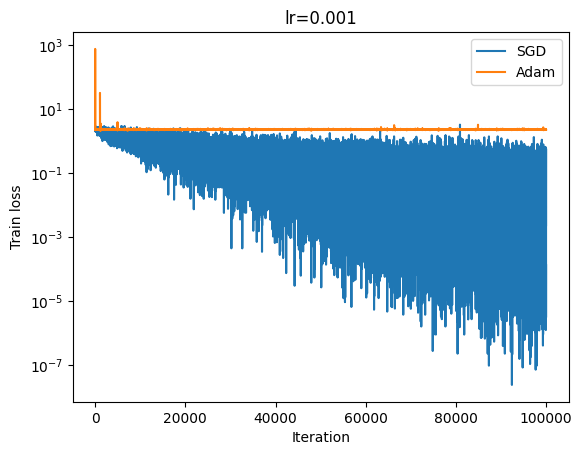

In [26]:
for lr in lr_range:
    plt.figure()
    plt.title("lr={}".format(lr))
    for m in conv_lr[lr]:
        plt.plot(conv_lr[lr][m], label=m)
    plt.yscale("log")
    plt.legend()
    plt.xlabel("Iteration")
    plt.ylabel("Train loss")

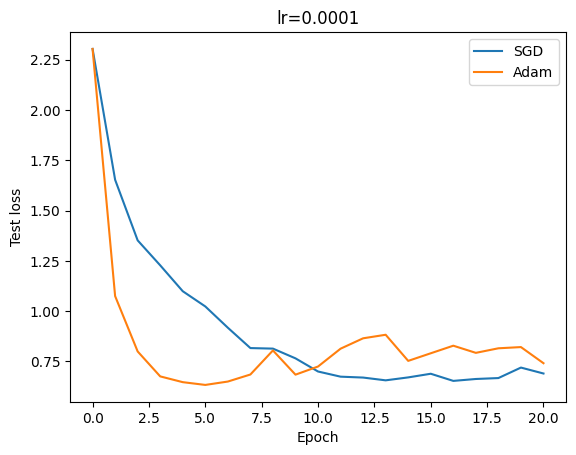

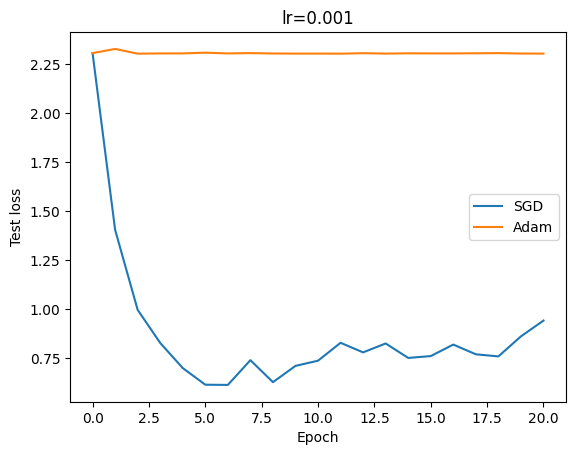

In [27]:
for lr in lr_range:
    plt.figure()
    plt.title("lr={}".format(lr))
    for m in test_losses_lr[lr]:
        plt.plot([t_l.cpu() for t_l in test_losses_lr[lr][m]], label=m)
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Test loss")

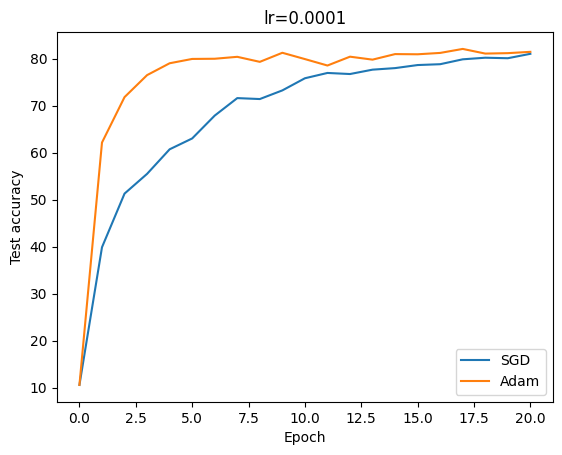

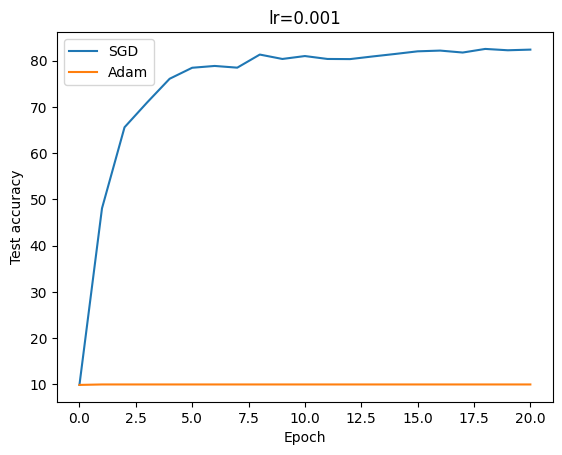

In [28]:
for lr in lr_range:
    plt.figure()
    plt.title("lr={}".format(lr))
    for m in test_losses_lr[lr]:
        plt.plot([t_l.cpu() for t_l in test_acc_lr[lr][m]], label=m)
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Test accuracy")

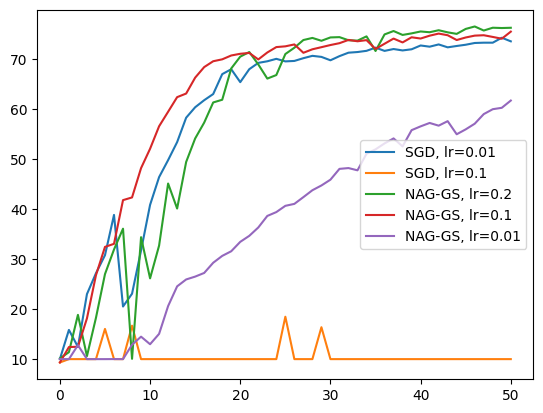

In [34]:
plt.plot([t_l.cpu() for t_l in test_acc_lr[0.01]["SGD"]], label="SGD, lr=0.01")
plt.plot([t_l.cpu() for t_l in test_acc_lr[0.1]["SGD"]], label="SGD, lr=0.1")
plt.plot([t_l.cpu() for t_l in test_acc_lr[0.2]["NAG-GS"]], label="NAG-GS, lr=0.2")
plt.plot([t_l.cpu() for t_l in test_acc_lr[0.1]["NAG-GS"]], label="NAG-GS, lr=0.1")
plt.plot([t_l.cpu() for t_l in test_acc_lr[0.01]["NAG-GS"]], label="NAG-GS, lr=0.01")
plt.legend()

In [46]:
# import time
# import datetime
# now = datetime.datetime.now()
# print(now.strftime("%d.%m.%Y_%H:%M:%S"))

25.04.2023_06:45:39


In [54]:
# import datetime
# now = datetime.datetime.now()
# np.savez("./vgg11_result_{}_adam.npz".format(now.strftime("%d.%m.%Y_%H:%M:%S")),
#         test_acc_lr=test_acc_lr,
#         test_losses_lr=test_losses_lr,
#         config=config,
#         lr_range=lr_range,
#         conv_lr=conv_lr
#         )

In [36]:
test_loss, test_accuracy = validate_complete_data(test_loader, model_opt[0][0])

In [37]:
# torch.save(model_opt[0][0], "./nag-gs-lr0.01-224-epoch20")

In [38]:
test_accuracy

tensor(82.3600, device='cuda:0')

In [42]:
torch.save({
            'model_sgd': model_opt[0][0].state_dict(),
#             'model_adam': model_opt[1][0],
            'sgd_state_dict': model_opt[0][1].state_dict(),
#             'adam_state_dict': model_opt[1][1].state_dict(),
            'test_loss': test_losses_lr,
            'test_acc_lr': test_acc_lr,
            'config': config,
            'lr_range': lr_range
            }, "./vgg19_sgd_224_1e-3_bsize10_epoch20")